# Interacting with CLIP

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [1]:
# # ! python -m pip install --upgrade pip
# ! pip install ftfy regex tqdm
# ! pip install git+https://github.com/openai/CLIP.git

# ! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# # ! pip install --upgrade --force-reinstall torch==2.2.1 torchvision==0.17.1 torchaudio==2.2.1
# # (use --upgrade --force-reinstall to upgrade)

# ! pip install scikit-image
# ! pip install matplotlib
# ! pip install opencv-python
# ! pip install setuptools

In [1]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)
print(torch. cuda. is_available())
print("CUDA version:", torch.version.cuda)

Torch version: 2.3.0+cu118
True
CUDA version: 11.8


C:\Users\AlexTerentowicz\AppData\Local\Temp\ipykernel_8872\2822029800.py:3: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import packaging


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [6]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [4]:
import clip

model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

e:\repos_kioxia\win\mgr\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
e:\repos_kioxia\win\mgr\.venv\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [5]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [6]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x000001AC9A6987C0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [7]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

### Video dataset example

In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import save_image
import json

frame_types = ["frame_first", "frame_half", "frame_last", "comic_3", "comic_4"]

def vid_path(filename):
    return f'.\\data\\video\\train_all\\{filename}'

def load_video(filename):
    cap = cv2.VideoCapture(filename)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return np.array(frames)

def load_utt(vid_no, utt_no, text_data):
    utt = text_data[vid_no]['conversation'][utt_no-1]
    vid = load_video(vid_path(utt['video_name']))
    return vid, utt

def load_frame(fname, frame_type):
    path = f'./data/preproc/{frame_type}/{fname}.jpg'
    frame = cv2.imread(path)
    return frame

def frame_to_img(frame):
    # frame = Image.fromarray(frame).convert("RGB")
    # frame = Image.fromarray(np.array(frame)[:, :, ::-1])
    
    frame = Image.fromarray(frame[:, :, ::-1])
    return  frame

with open('data/Subtask_2_train.json') as f:
    text_data_list = json.load(f)
    # text data is a map of conversation id to conversation
    text_data = {text['conversation_ID']: text for text in text_data_list}

./data/preproc/comic_4/dia1utt1.jpg


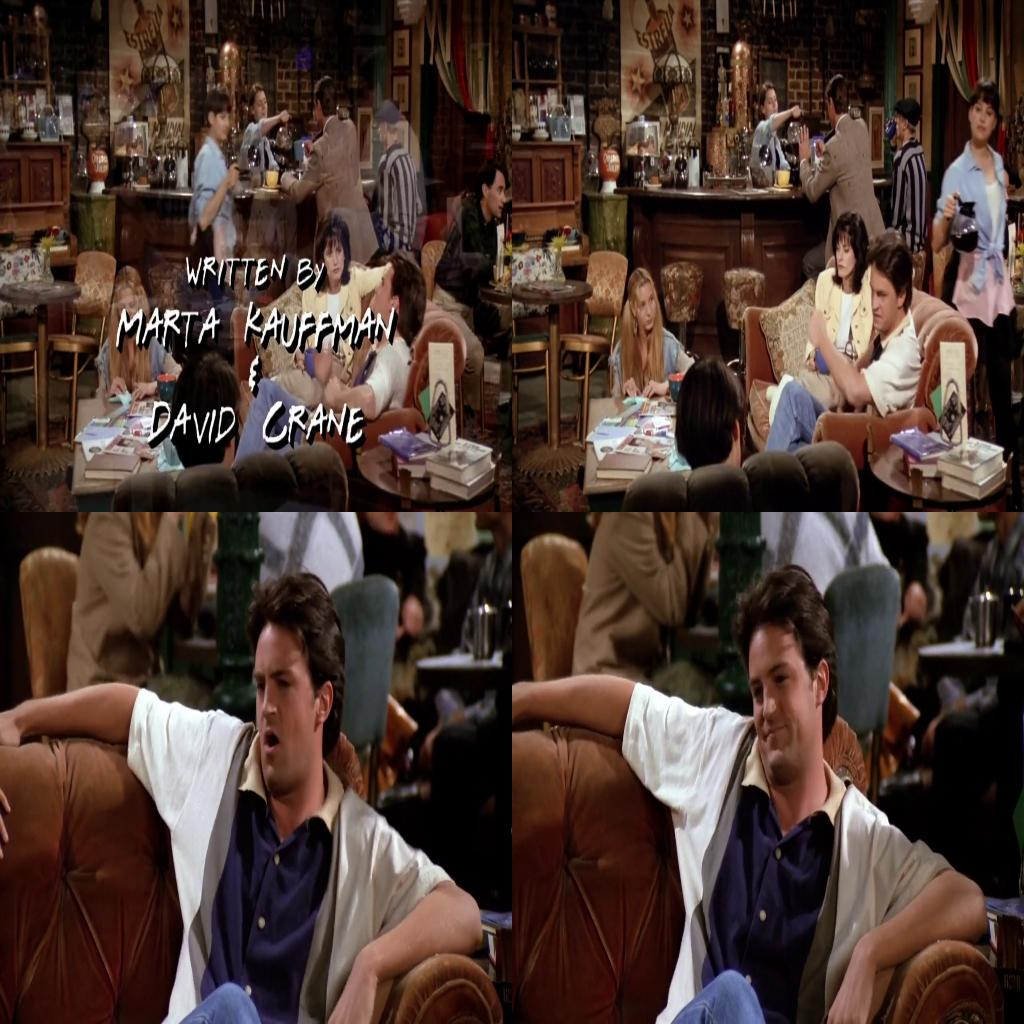

In [29]:
fname = text_data[1]['conversation'][0]['video_name'][:-4]
frame = load_frame(fname, frame_types[4])
frame_to_img(frame)

In [18]:
len(text_data)

1374

dia215utt4
./data/preproc/frame_first/dia215utt4.jpg


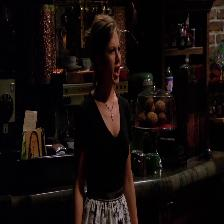

In [30]:
fname = text_data[215]['conversation'][3]['video_name'][:-4]
print(fname)
frame = load_frame(fname, frame_types[0])
frame_to_img(frame)

## Prepare images for encoding

In [31]:
import os


print(len(text_data))

utt_count = 0
for key in text_data:
    utt_count += len(text_data[key]['conversation'])
print("Number of utterances: ", utt_count)

# count number of videos in dir
path = './data/video/train_all'
files = os.listdir(path)
print("Number of videos: ", len(files))
    

1374
Number of utterances:  13619
Number of videos:  13619


In [14]:
frame_types

['frame_first', 'frame_half', 'frame_last', 'comic_3', 'comic_4']

In [34]:
import time

n_videos = len(text_data)
# frame_type = frame_types[4]
# original_images = []

batchsize = 10
batches = [list(text_data.keys())[i:i + batchsize] for i in range(0, len(text_data), batchsize)]
st = time.time()


for frame_type in frame_types:
    image_features_all = torch.empty(0, 512).cuda()
    text_features_all = torch.empty(0, 512).cuda()
    encoded_convs_utts = []

    for en_b, batch in enumerate(batches):
        images = []
        texts = []
        labels = []
        for c_i in batch:
            
            conv_dict = text_data[c_i]
            for utt_dict in conv_dict['conversation']:
                u_i = utt_dict['utterance_ID']

                fname = utt_dict['video_name'][:-4]
                frame = load_frame(fname, frame_type)
                if frame is None:
                    continue
                else:
                    encoded_convs_utts.append((c_i, u_i))

                frame = frame_to_img(frame)

                # original_images.append(frame)
                images.append(preprocess(frame))
                texts.append(utt_dict['text'][:250])
                labels.append(utt_dict['emotion'])

        if len(images) < 1:
            print("skipped empty images in ", frame_type, c_i, u_i)
            continue

        image_input = torch.tensor(np.stack(images)).cuda()
        text_tokens = clip.tokenize(["" + desc for desc in texts]).cuda()

        with torch.no_grad():
            image_features = model.encode_image(image_input).float()
            text_features = model.encode_text(text_tokens).float()

        # concatenate features to features_all
        image_features_all = torch.cat((image_features_all, image_features))
        text_features_all = torch.cat((text_features_all, text_features))

        print(f"[{np.round(time.time()-st, 2)}] [{frame_type}] finished batch {en_b}")

    torch.save(image_features_all, f'./data/features/{frame_type}/image_features.pt')
    torch.save(text_features_all, f'./data/features/{frame_type}/text_features.pt')
    torch.save(encoded_convs_utts, f'./data/features/{frame_type}/encoded_convs_utts.pt')



[0.24] [frame_first] finished batch 0
[0.56] [frame_first] finished batch 1
[0.9] [frame_first] finished batch 2
[1.85] [frame_first] finished batch 3
[2.77] [frame_first] finished batch 4
[3.89] [frame_first] finished batch 5
[5.29] [frame_first] finished batch 6
[6.26] [frame_first] finished batch 7
[6.77] [frame_first] finished batch 8
[7.75] [frame_first] finished batch 9
[9.08] [frame_first] finished batch 10
[9.93] [frame_first] finished batch 11
[10.75] [frame_first] finished batch 12
[11.55] [frame_first] finished batch 13
[12.15] [frame_first] finished batch 14
[12.97] [frame_first] finished batch 15
[13.62] [frame_first] finished batch 16
[14.55] [frame_first] finished batch 17
[15.48] [frame_first] finished batch 18
[16.35] [frame_first] finished batch 19
[17.24] [frame_first] finished batch 20
[18.04] [frame_first] finished batch 21
[18.78] [frame_first] finished batch 22
[19.46] [frame_first] finished batch 23
[20.32] [frame_first] finished batch 24
[21.24] [frame_first] f

In [35]:
frame_type = frame_types[4]
path = f'./data/features/{frame_type}'
image_features = torch.load(f'{path}/image_features.pt')
text_features = torch.load(f'{path}/text_features.pt')
encoded_convs_utts = torch.load(f'{path}/encoded_convs_utts.pt')
print(len(encoded_convs_utts))

13619


9966


## Prepare encodings and labels for classification

In [38]:
text_data_filtered = text_data.copy()
for c_id, conv in text_data.items():
    text_data_filtered[c_id]['conversation'] = [utt for utt in conv['conversation'] if (c_id, utt['utterance_ID']) not in missing_encodings[frame_types[4]]]

n_utts = 0
labels = []
for c_id, conv in text_data_filtered.items():
    n_utts += len(conv['conversation'])
    labels += [utt['emotion'] for utt in conv['conversation']]

print(len(labels))

13619


In [39]:
import pandas as pd
pd.Series(labels).value_counts()

neutral     5929
joy         2301
surprise    1840
anger       1615
sadness     1147
disgust      414
fear         373
Name: count, dtype: int64

In [40]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

onehot_encoder = OneHotEncoder()
Y = onehot_encoder.fit_transform(np.array(labels).reshape(-1, 1))
Y = torch.tensor(Y.toarray()).cuda()

In [41]:
frame_type = frame_types[4]
path = f'./data/features/{frame_type}'
image_features = torch.load(f'{path}/image_features.pt')
text_features = torch.load(f'{path}/text_features.pt')

X = torch.cat((image_features, text_features), dim=1)
X.shape

torch.Size([13619, 1024])

In [42]:
print(torch.isnan(X).sum(), torch.isnan(Y).sum())

tensor(0, device='cuda:0') tensor(0, device='cuda:0')


: 

## Classification